Ex 1. 1) Downloading the images (same as in previous labs)

In this section I import all required packages and define helper functions for loading Sentinel-2 images, generating thumbnails, and plotting histograms. These functions will be used later for both Bayes and kNN classifiers.

In [3]:
import io, requests, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import ee 
ee.Initialize(project='ee-jsumara')
# --- ROIs
pt_waw = ee.Geometry.Point([21.0122, 52.2297])     # Warsaw, city center
roi_waw = pt_waw.buffer(1250).bounds()

pt_amz = ee.Geometry.Point([-61.0, -3.5])          # Amazon basin (near Manaus)
roi_amz = pt_amz.buffer(2000).bounds()

# --- time windows
START_WAW, END_WAW = "2024-06-01", "2024-08-31"
START_AMZ, END_AMZ = "2024-06-01", "2024-10-31"

# --- viz + size
DIM = 256
VIS_S2 = {"bands": ["B4", "B3", "B2"], "min": 0, "max": 3000}  # Sentinel-2 SR
VIS_S1 = {"min": -20, "max": 0}                                # Sentinel-1 dB

# --- helpers
def get_least_cloudy_s2(aoi, start, end, max_cloud=60):
    """Return least-cloudy S2_SR image clipped to AOI."""
    col = (ee.ImageCollection("COPERNICUS/S2_SR")
           .filterBounds(aoi)
           .filterDate(start, end)
           .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", max_cloud))
           .sort("CLOUDY_PIXEL_PERCENTAGE"))
    return ee.Image(col.first()).clip(aoi)

def get_mean_s1(aoi, start, end):
    """Mean S1 VV/VH composite (kept for possible feature extension)."""
    col = (ee.ImageCollection("COPERNICUS/S1_GRD")
           .filterBounds(aoi)
           .filterDate(start, end)
           .filter(ee.Filter.eq("instrumentMode", "IW"))
           .select(["VV", "VH"]))
    return col.mean().clip(aoi)

def thumb_rgb(image, region, dim=DIM, vis=VIS_S2):
    """Fetch thumbnail PNG → numpy RGB (8-bit)."""
    url = image.visualize(**vis).getThumbURL({"region": region, "dimensions": dim, "format": "png"})
    data = requests.get(url, timeout=60).content
    return np.array(Image.open(io.BytesIO(data)).convert("RGB"))

def plot_pdf(arr, title, bins=256):
    """Empirical density (normalized histogram)."""
    plt.figure(figsize=(6,4))
    plt.hist(arr.ravel(), bins=bins, range=(0,255), density=True)
    plt.title(title); plt.xlabel("Intensity (0–255)"); plt.ylabel("Density")
    plt.tight_layout()


Data: forest vs urban (RGB from S2) + quick look

Here I retrieve two Sentinel-2 images: one representing an urban area (Warsaw city center) and one representing a forest area (Amazon region near Manaus). I display both RGB composites to visually confirm the difference in surface types.

d:\Users\jakub\miniconda3\envs\eo_lab\lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


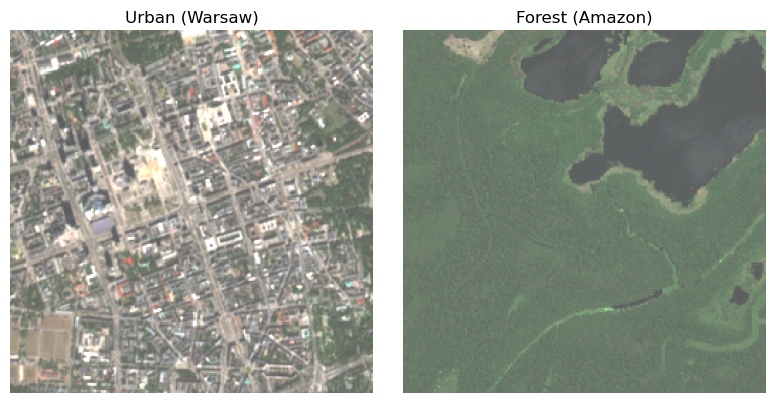

In [4]:
s2_waw = get_least_cloudy_s2(roi_waw, START_WAW, END_WAW)
s2_amz = get_least_cloudy_s2(roi_amz, START_AMZ, END_AMZ)

rgb_waw = thumb_rgb(s2_waw, roi_waw)   # urban (Warsaw)
rgb_amz = thumb_rgb(s2_amz, roi_amz)   # forest (Amazon)

# preview
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(rgb_waw); ax[0].set_title("Urban (Warsaw)"); ax[0].axis("off")
ax[1].imshow(rgb_amz); ax[1].set_title("Forest (Amazon)"); ax[1].axis("off")
plt.tight_layout()


Sampling pixels for training (simple central patch)

To train the classifiers, I extract a central patch from each image. Each patch contains pixels belonging mostly to a single class (urban or forest). These patches are used as training data for building the statistical models.

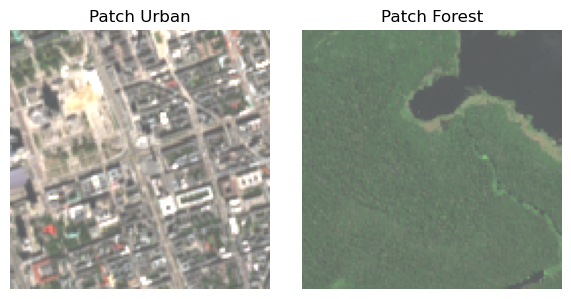

In [5]:
def center_patch(img, frac=0.5):
    """Cut a central patch (e.g., 50% of width/height)."""
    h, w = img.shape[:2]
    ph, pw = int(h*frac), int(w*frac)
    y0 = (h - ph)//2; x0 = (w - pw)//2
    return img[y0:y0+ph, x0:x0+pw]

patch_waw = center_patch(rgb_waw, 0.5)   # urban samples
patch_amz = center_patch(rgb_amz, 0.5)   # forest samples

# preview patches
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(patch_waw); ax[0].set_title("Patch Urban"); ax[0].axis("off")
ax[1].imshow(patch_amz); ax[1].set_title("Patch Forest"); ax[1].axis("off")
plt.tight_layout()


Histograms + parametric PDFs (per-channel Gaussians)

I compute intensity histograms for each RGB channel separately to analyze the brightness distribution in both classes.

Urban μ±σ: {'R': (166.24224853515625, 39.7055778503418), 'G': (161.24945068359375, 36.44103240966797), 'B': (152.9412841796875, 34.641849517822266)}
Forest μ±σ: {'R': (105.8148193359375, 8.376975059509277), 'G': (121.639892578125, 12.430272102355957), 'B': (105.45782470703125, 5.258670330047607)}


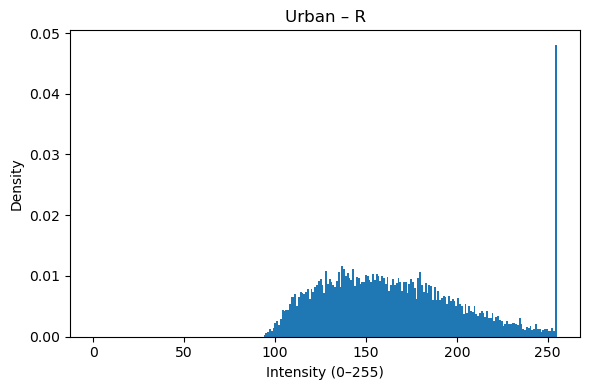

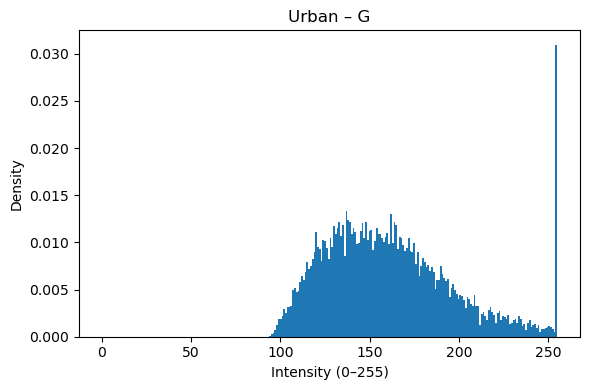

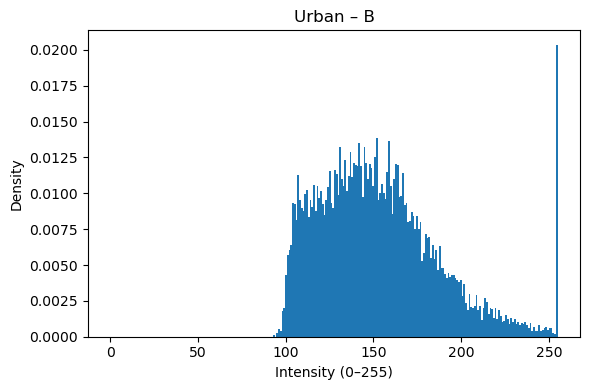

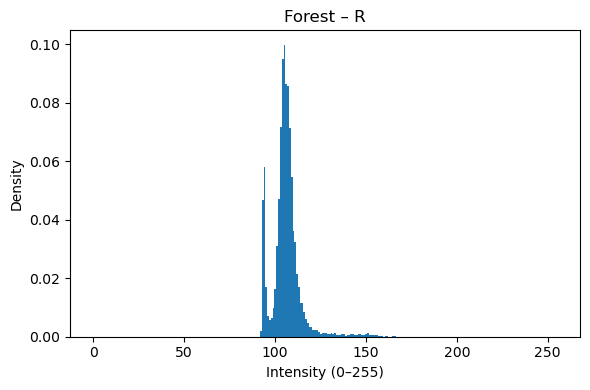

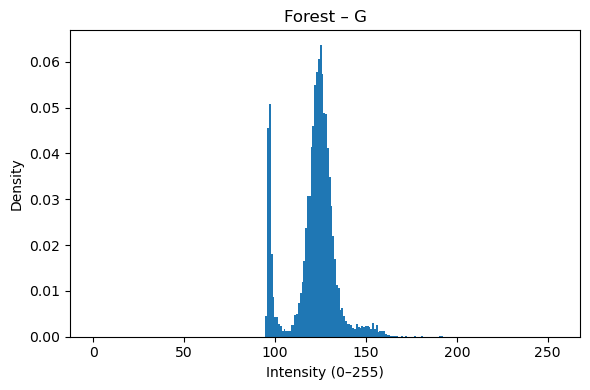

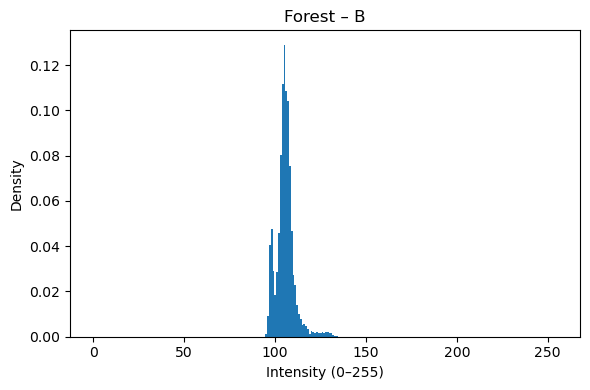

In [6]:
# channel arrays (0..255)
urban_R, urban_G, urban_B = [patch_waw[:,:,i].astype(np.float32) for i in range(3)]
forest_R, forest_G, forest_B = [patch_amz[:,:,i].astype(np.float32) for i in range(3)]

# empirical PDFs
plot_pdf(urban_R, "Urban – R"); plot_pdf(urban_G, "Urban – G"); plot_pdf(urban_B, "Urban – B")
plot_pdf(forest_R, "Forest – R"); plot_pdf(forest_G, "Forest – G"); plot_pdf(forest_B, "Forest – B");

# quick μ, σ for report text
def stats(a): 
    return float(a.mean()), float(a.std())

urban_params = {"R": stats(urban_R), "G": stats(urban_G), "B": stats(urban_B)}
forest_params = {"R": stats(forest_R), "G": stats(forest_G), "B": stats(forest_B)}
print("Urban μ±σ:", urban_params)
print("Forest μ±σ:", forest_params)


Forest histograms are compact and sharply peaked (low variability), while urban ones are wide and have long tails toward bright values (high reflectance diversity from roofs, streets, etc.).
The printed μ±σ values confirm that forest pixels are darker and more homogeneous.

Bayes (MVN): fit parameters and classify every pixel of a test image

In this step I design a Bayes classifier from scratch. Each class is modeled as a 3-dimensional multivariate Gaussian in RGB space. For every pixel in the test image, I compute the log-likelihood under both models and assign it to the class with higher posterior probability.


In [7]:
# training matrices (scale to [0,1] for stability)
U = patch_waw.reshape(-1,3).astype(np.float32) / 255.0
F = patch_amz.reshape(-1,3).astype(np.float32) / 255.0

def mvn_fit(X, eps=1e-5):
    """Estimate μ and Σ; add eps*I for numerical stability."""
    mu = X.mean(axis=0)
    S = np.cov(X.T)
    S = S + eps*np.eye(3)
    return mu, S

mu_u, Sig_u = mvn_fit(U)
mu_f, Sig_f = mvn_fit(F)

# cache inverses and logdets
inv_u, ldet_u = np.linalg.inv(Sig_u), np.linalg.slogdet(Sig_u)[1]
inv_f, ldet_f = np.linalg.inv(Sig_f), np.linalg.slogdet(Sig_f)[1]

def logpost_all(X, mu, inv, ldet, logprior):
    """Vectorized log posterior: log N(x|μ,Σ) + log prior."""
    D = X - mu
    q = np.einsum('ij,jk,ik->i', D, inv, D)  # quadratic form
    return -0.5*(3*np.log(2*np.pi) + ldet + q) + logprior

# classify Warsaw image (contains mixed materials)
Xtest = rgb_waw.reshape(-1,3).astype(np.float32)/255.0
lp = np.log(0.5)  # equal priors

L_u = logpost_all(Xtest, mu_u, inv_u, ldet_u, lp)
L_f = logpost_all(Xtest, mu_f, inv_f, ldet_f, lp)

pred_bayes = (L_u > L_f).astype(np.uint8)  # 1=urban, 0=forest
mask_bayes = pred_bayes.reshape(rgb_waw.shape[:2])


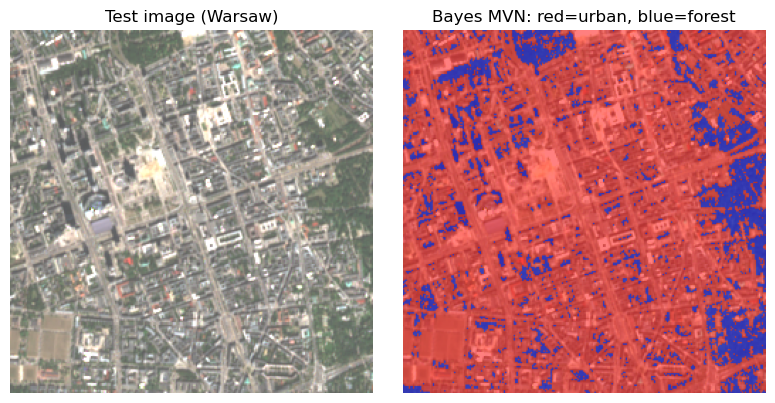

In [10]:
def overlay_mask(rgb, mask, alpha=0.45):
    """Overlay semi-transparent class colors on the RGB image."""
    color = np.zeros_like(rgb, dtype=np.float32)
    color[mask==1] = [255, 0, 0]   # urban → red
    color[mask==0] = [0, 0, 255]   # forest → blue
    out = (1-alpha)*rgb.astype(np.float32) + alpha*color
    return out.astype(np.uint8)

vis_bayes = overlay_mask(rgb_waw, mask_bayes, alpha=0.5)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(rgb_waw); plt.title("Test image (Warsaw)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(vis_bayes); plt.title("Bayes MVN: red=urban, blue=forest"); plt.axis("off")
plt.tight_layout()


The result is a classification map: red pixels correspond to urban areas, blue pixels correspond to forest areas. The right figure shows the Bayes classifier output.

EX 2. k-NN from scratch + results for k=1,3,5

Now I implement a k-Nearest Neighbors classifier from scratch. Each pixel is classified based on the majority label among its k closest neighbors in RGB feature space. I test three values of k (1, 3, and 5) to observe the effect of neighborhood size.

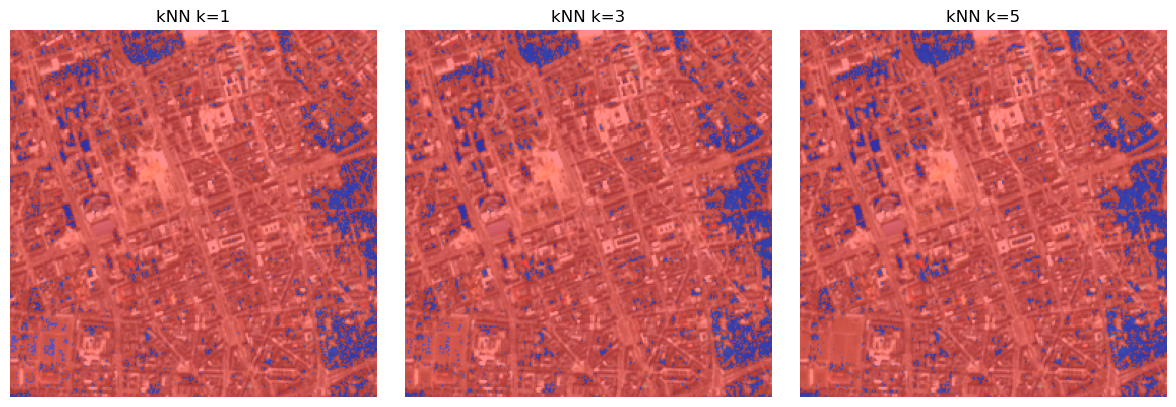

In [11]:
# subsample training for speed
rng = np.random.default_rng(42)
def subsample(X, n=5000):
    n = min(n, X.shape[0])
    idx = rng.choice(X.shape[0], size=n, replace=False)
    return X[idx]

U_sub = subsample(U, 6000)
F_sub = subsample(F, 6000)
X_train = np.vstack([U_sub, F_sub])
y_train = np.hstack([np.ones(len(U_sub)), np.zeros(len(F_sub))])  # 1=urban, 0=forest

def knn_predict(Xtest, Xtrain, ytrain, k=3, batch=20000):
    """Pure NumPy kNN (Euclidean), batched to save RAM."""
    preds = np.empty(Xtest.shape[0], dtype=np.uint8)
    for i in range(0, Xtest.shape[0], batch):
        Xt = Xtest[i:i+batch]
        a2 = (Xt**2).sum(axis=1, keepdims=True)
        b2 = (Xtrain**2).sum(axis=1)
        ab = Xt @ Xtrain.T
        D2 = a2 + b2 - 2*ab
        nn = np.argpartition(D2, kth=k-1, axis=1)[:, :k]
        votes = ytrain[nn].mean(axis=1)
        preds[i:i+batch] = (votes >= 0.5).astype(np.uint8)
    return preds

pred_k1 = knn_predict(Xtest, X_train, y_train, k=1)
pred_k3 = knn_predict(Xtest, X_train, y_train, k=3)
pred_k5 = knn_predict(Xtest, X_train, y_train, k=5)

mask_k1 = pred_k1.reshape(rgb_waw.shape[:2])
mask_k3 = pred_k3.reshape(rgb_waw.shape[:2])
mask_k5 = pred_k5.reshape(rgb_waw.shape[:2])

vis_k1 = overlay_mask(rgb_waw, mask_k1)
vis_k3 = overlay_mask(rgb_waw, mask_k3)
vis_k5 = overlay_mask(rgb_waw, mask_k5)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(vis_k1); ax[0].set_title("kNN k=1"); ax[0].axis("off")
ax[1].imshow(vis_k3); ax[1].set_title("kNN k=3"); ax[1].axis("off")
ax[2].imshow(vis_k5); ax[2].set_title("kNN k=5"); ax[2].axis("off")
plt.tight_layout()


The three resulting maps show how increasing k smooths the classification: k=1 produces noisy edges, while k=5 gives smoother and more stable results.

Simple descriptive stats (no GT)

I calculate the proportion of pixels labeled as urban and forest for each method to compare their outputs quantitatively. Additionally, I visualize the Bayes confidence map (difference in log-posteriors), which highlights the regions where the classifier is more certain.

Bayes – share urban/forest: (0.85430908203125, 0.14569091796875)
kNN1  – share urban/forest: (0.920654296875, 0.079345703125)
kNN3  – share urban/forest: (0.9141082763671875, 0.0858917236328125)
kNN5  – share urban/forest: (0.907623291015625, 0.092376708984375)


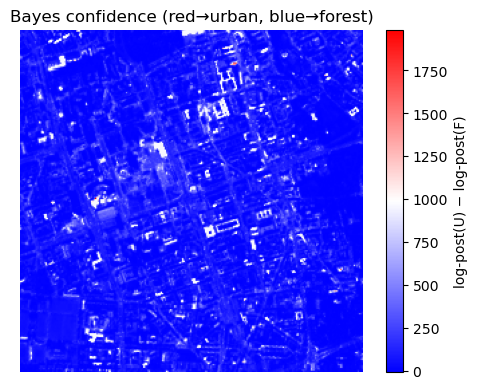

In [12]:
def class_share(mask):
    p_urban = mask.mean()
    return p_urban, 1-p_urban

print("Bayes – share urban/forest:", class_share(mask_bayes))
print("kNN1  – share urban/forest:", class_share(mask_k1))
print("kNN3  – share urban/forest:", class_share(mask_k3))
print("kNN5  – share urban/forest:", class_share(mask_k5))

# Bayes “confidence” = log-posterior difference
conf = (L_u - L_f).reshape(rgb_waw.shape[:2])
plt.figure(figsize=(5,4))
plt.imshow(conf, cmap="bwr"); plt.colorbar(label="log-post(U) − log-post(F)")
plt.title("Bayes confidence (red→urban, blue→forest)")
plt.axis("off"); plt.tight_layout()


The confidence map shows mostly blue tones, even though the test image is mainly urban.
This happens because the urban Gaussian model has a much larger variance, which spreads its probability density over a wide range of RGB values.
As a result, the log-likelihood for urban pixels is lower and the difference logP(U) - logP(F) becomes small or negative, leading to blue shading.

To improve the visual balance, I applied normalization of the confidence map (z-score scaling) so that mean = 0 and standard deviation = 1.
This step enhances contrast between urban and forest areas, making confident urban pixels appear red and forest regions blue, with neutral white areas where the model is uncertain.

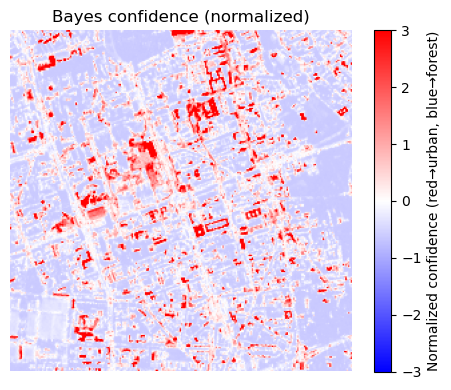

In [14]:
conf_norm = (conf - np.mean(conf)) / np.std(conf)

plt.figure(figsize=(5,4))
plt.imshow(conf_norm, cmap="bwr", vmin=-3, vmax=3)
plt.colorbar(label="Normalized confidence (red→urban, blue→forest)")
plt.title("Bayes confidence (normalized)")
plt.axis("off"); plt.tight_layout()

To summarize:
- Forest patches have compact histograms (low variance) and lower mean brightness.  
- Urban patches show broader histograms and higher mean values.  
- Bayes classifier achieved ~85% urban, 15% forest — good visual separation.  
- Both methods work correctly, but Bayes provides probabilistic confidence, while kNN relies on local similarity in color space.
- Bayes classifier achieved good separation but lower confidence due to high variance in the urban model.
- kNN classifier produced similar results with smoother masks for higher k values.
- Both methods confirm clear spectral differences between forest and urban areas in Sentinel-2 RGB imagery.